In [25]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
library(Rcpp)


library(rpart)# Popular decision tree algorithm
#install.packages('rattle')
library(rattle)# Fancy tree plot
library(rpart.plot)# Enhanced tree plots
library(RColorBrewer)# Color selection for fancy tree plot
library(party) # Alternative decision tree algorithm
#install.packages('partykit')
library(partykit)# Convert rpart object to BinaryTree

#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')


#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)
#install.packages("scales")
library(scales)
#update.packages()
#install.packages("packagename")
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#install.packages("stats4")
#install.packages("splines")
library(stats4) #Load package stats
library(splines) #Load package splines
#To load package VGAM, need to load package stats4 and splines.
#install.packages("VGAM")
library(VGAM) #Load package VGAM


#install.packages("psych")
#install.packages("PerformanceAnalytics")
library(corrplot)
library(PerformanceAnalytics)
library(psych)

library(data.table)
library(writexl)



# FA (weighted) Classifcation

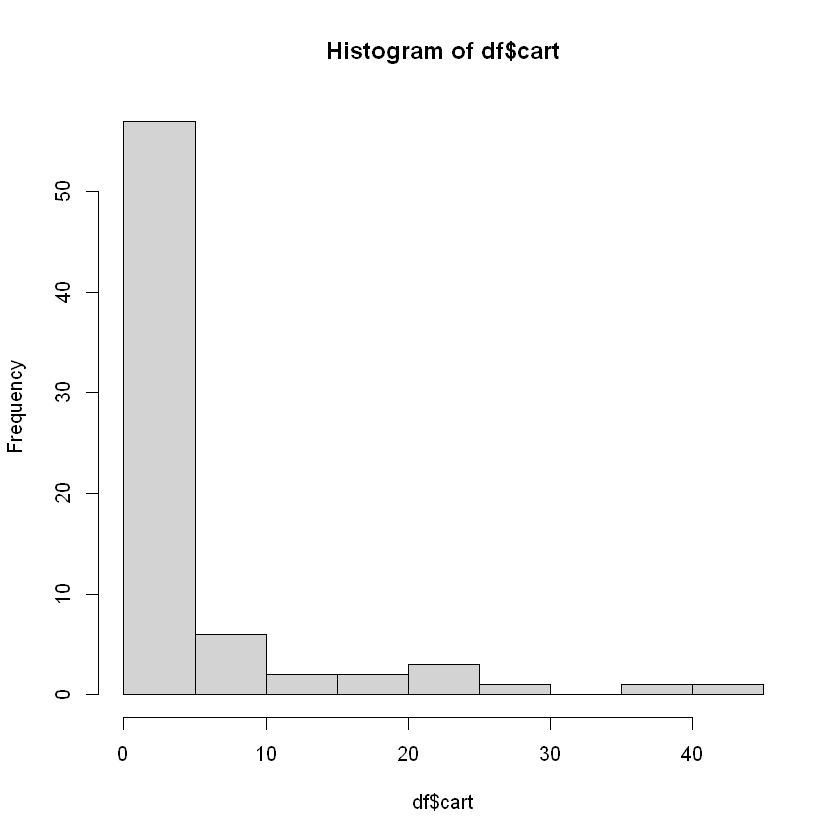

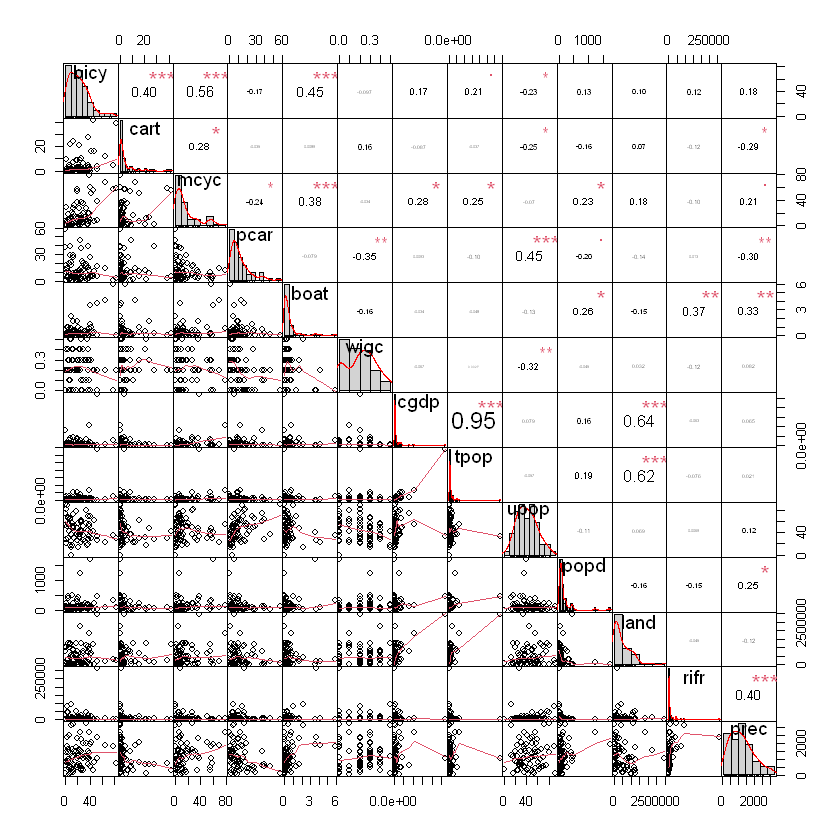

In [26]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-seven-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))

df <- df[, c(1:13, 17,21)]

#scaling the world bank data similar to DHS aggregation out of 100
df.wb <- df[,c(9:15)]
df.wb <- data.frame(lapply(df.wb, function(x) scale(x, center = FALSE, scale = max(x, na.rm = TRUE)/100)))
df.scale <- cbind(df, df.wb)
df.scale <- df.scale[,c(1:8,15:21)]


df.a <- df[, c(1:6,8)]
hist(df$cart)

explnatory <- df[,c(2:7, 9:15)]
chart.Correlation(explnatory, histogram=TRUE, pch=19 , tl.cex = .7 )
                           


In [27]:
# ""Off-premise", "Market", "Piping"
df <- df%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Off-premise",
    .$clusters=="2" ~ "Market",
    .$clusters=="3" ~ "Piping",
      ))

df.scale <- df.scale%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Off-premise",
    .$clusters=="2" ~ "Market",
    .$clusters=="3" ~ "Piping",
      ))


In [41]:
df$clusters <- as.factor(df$clusters)
df.scale$clusters <- as.factor(df.scale$clusters)
write_xlsx(df , '../../results/class.xlsx')
write_xlsx(df.scale , '../../results/class-scale.xlsx')
head(df)

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Piping,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Piping,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# Tree


Classification tree:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))

Variables actually used in tree construction:
[1] boat cgdp pcar popd prec

Root node error: 36/73 = 0.49315

n= 73 

        CP nsplit rel error  xerror    xstd
1 0.388889      0   1.00000 1.00000 0.11866
2 0.138889      1   0.61111 0.80556 0.11613
3 0.083333      2   0.47222 0.75000 0.11458
4 0.055556      3   0.38889 0.72222 0.11365
5 0.027778      4   0.33333 0.61111 0.10890
6 0.010000      6   0.27778 0.61111 0.10890


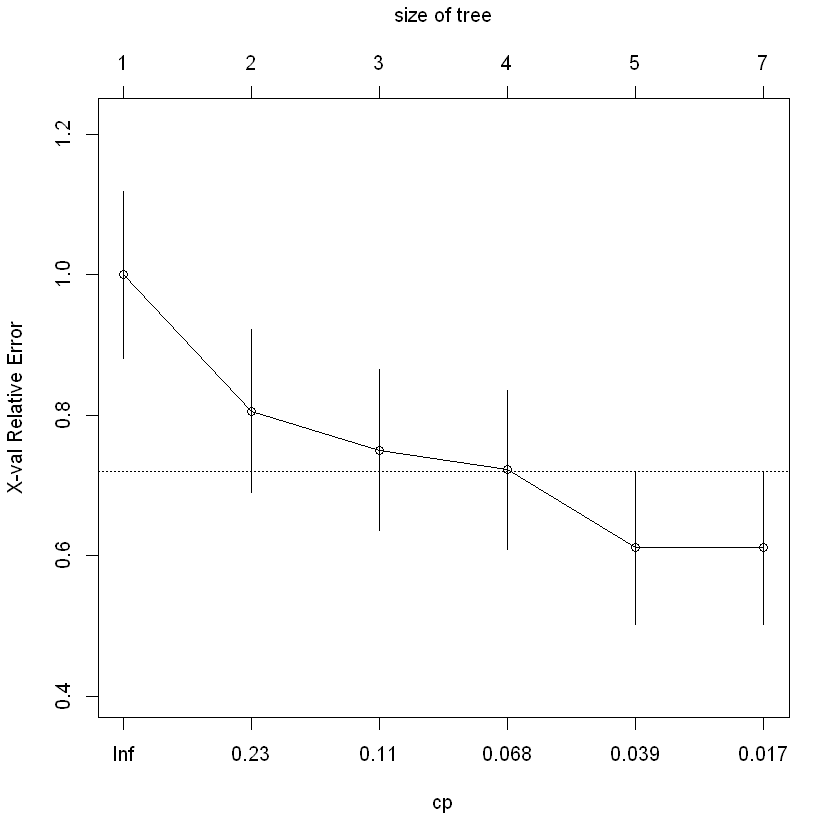

In [118]:
# Make big tree
form <- as.formula(clusters ~ . - Country)
tree.fwa <- rpart(form,data=df,control=rpart.control(minsplit=4,cp=0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4 )
                 )
#plot(tree.fwa)# Will make a mess of the plot
#text(tree.fwa)
plotcp(tree.fwa)
printcp(tree.fwa)
#summary(tree.fwa) 
#prp(tree.fwa)# Will plot the tree
#prp(tree.fwa,varlen=4)# Shorten variable names

ERROR: Error in legend(x = x, y = y, legend = legend, col = 0, xpd = NA, bty = "n", : argument 8 matches multiple formal arguments


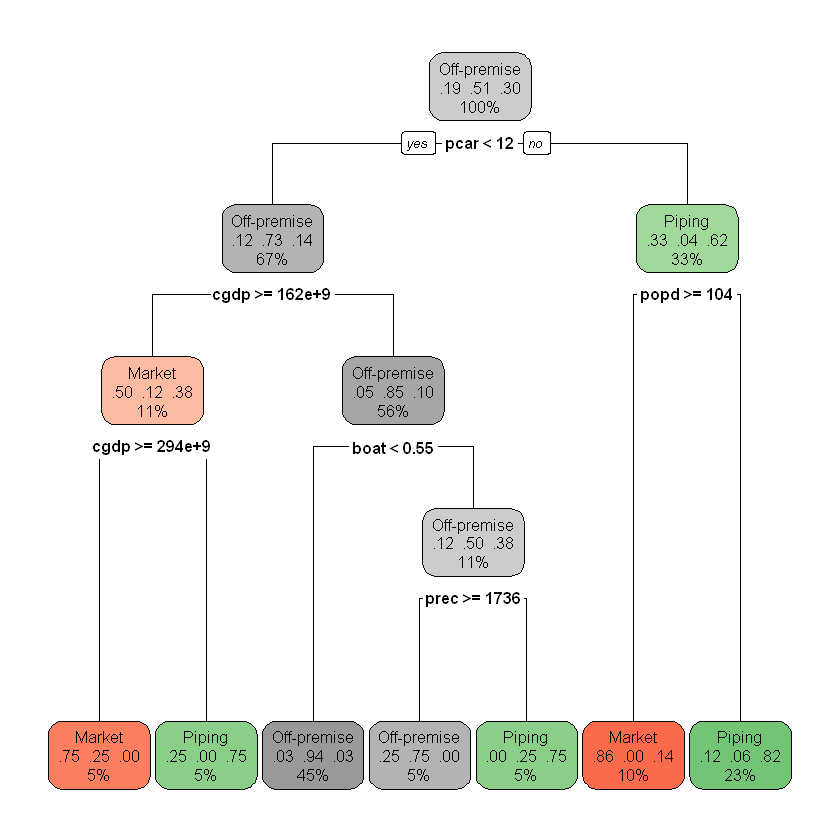

In [106]:
#Interatively prune the tree
tree.pru <- prune(tree.fwa, cp=0.01) # interactively trim the tree
#prp(tree.pru) # display the new tree
rpart.plot(tree.pru)

Call:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))
  n= 73 

          CP nsplit rel error    xerror      xstd
1 0.38888889      0 1.0000000 1.0000000 0.1186556
2 0.13888889      1 0.6111111 0.8055556 0.1161345
3 0.08333333      2 0.4722222 0.7500000 0.1145768
4 0.05555556      3 0.3888889 0.7222222 0.1136506
5 0.02777778      4 0.3333333 0.6111111 0.1089012
6 0.01000000      6 0.2777778 0.6111111 0.1089012

Variable importance
pcar cgdp popd boat prec 
  43   25   18    7    6 

Node number 1: 73 observations,    complexity param=0.3888889
  predicted class=Off-premise  expected loss=0.4931507  P(node) =1
    class counts:    14    37    22
   probabilities: 0.192 0.507 0.301 
  left son=2 (49 obs) right son=3 (24 obs)
  Primary splits:
      pcar < 12.4         to the left,  improve=12.198510, (0 missing)
      wigc < 0.25         to the right, improve= 6.923826, (0 missing)
      cgdp < 1097

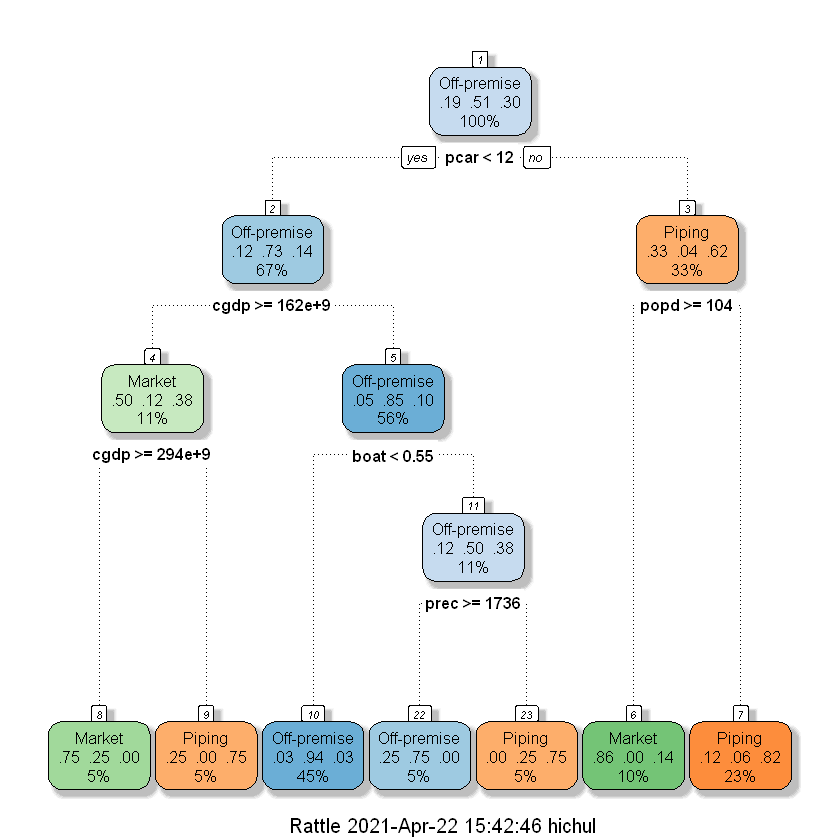

In [79]:
fancyRpartPlot(tree.pru)
summary(tree.pru)

Warning message:
"ignoring snip=TRUE for png device"


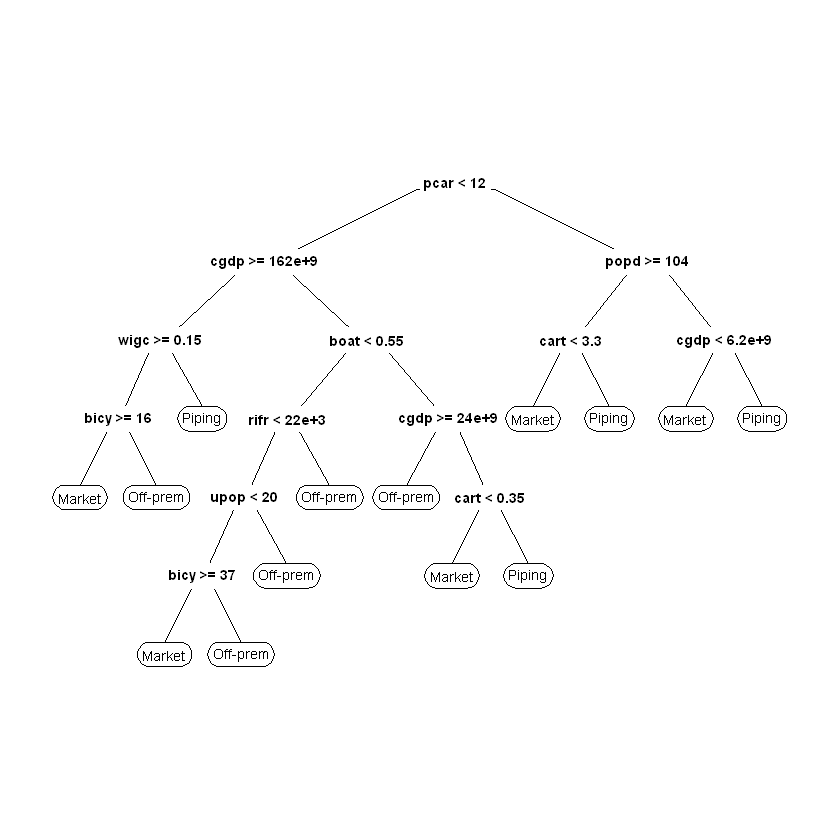

In [55]:
prp(tree.fwa, snip=TRUE)

http://www.milbo.org/rpart-plot/prp.pdf
http://www.di.fc.ul.pt/~jpn/r/tree/tree.html


Classification tree:
tree(formula = clusters ~ . - Country, data = df.scale)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

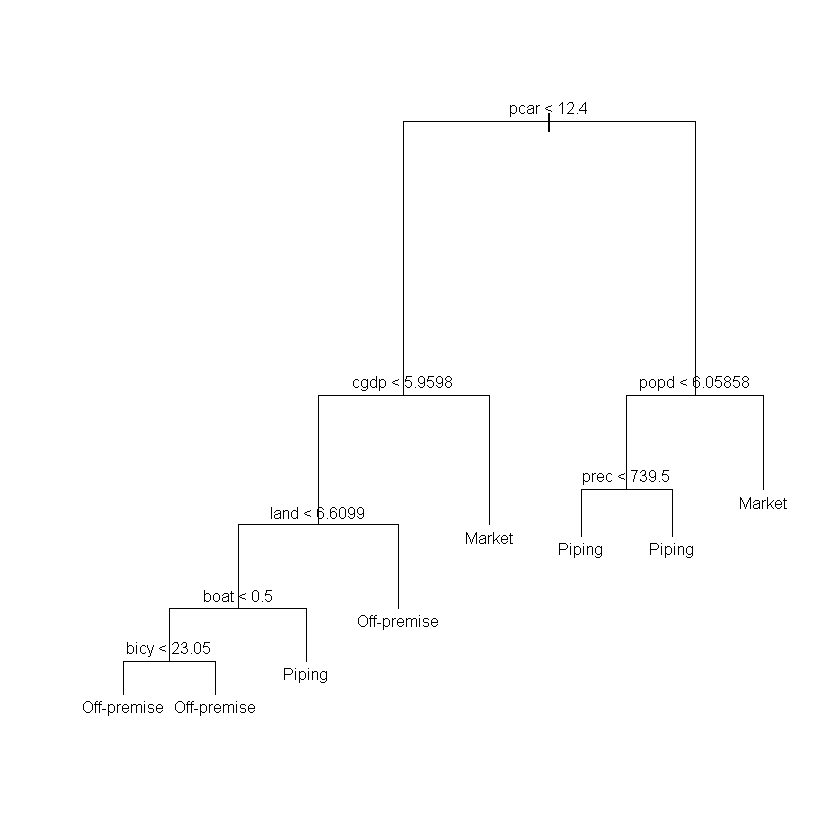

In [31]:
tree.wa = tree(clusters ~ . - Country  , data = df.scale)
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.8) 


Classification tree:
tree(formula = clusters ~ . - Country, data = df, mindev = 0.01)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

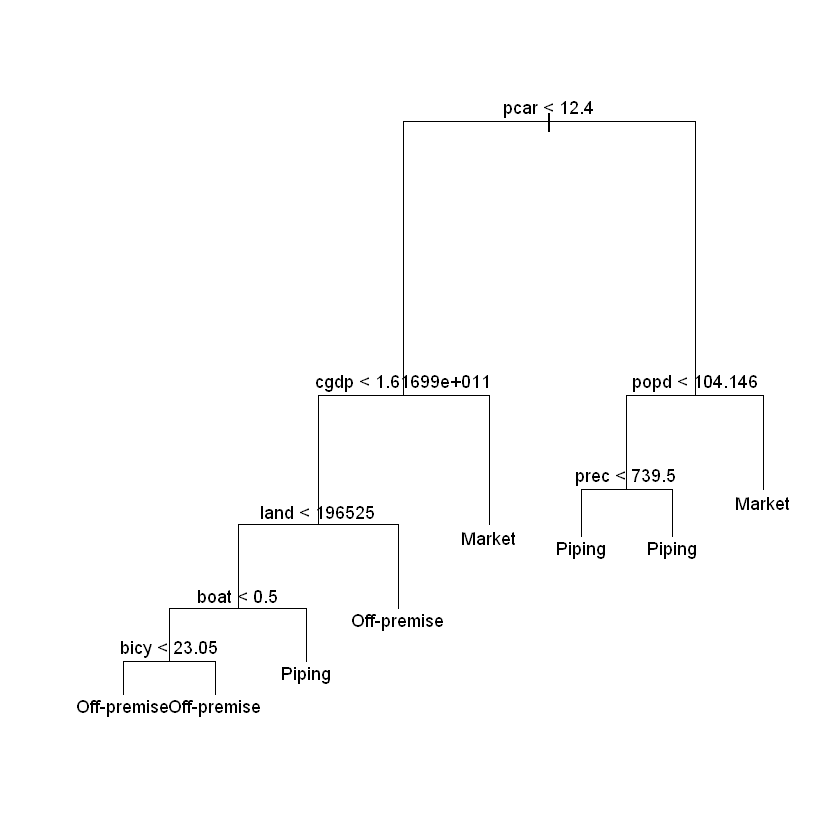

In [32]:
tree.wa = tree(clusters ~ . - Country  , data = df, mindev=0.01, )
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.90) 

# Distributional prediction
my.prediction <- predict(tree.wa) # gives the probability for each class
head(my.prediction)

# Point prediction
# Let's translate the probability output to categorical output
maxidx <- function(arr) {
    return(which(arr == max(arr)))
}
idx <- apply(my.prediction, c(1), maxidx)
prediction <- c("Worst Water Source", "Better Water Source", "Best Water Source")[idx]
table(prediction, df.scale$clusters)

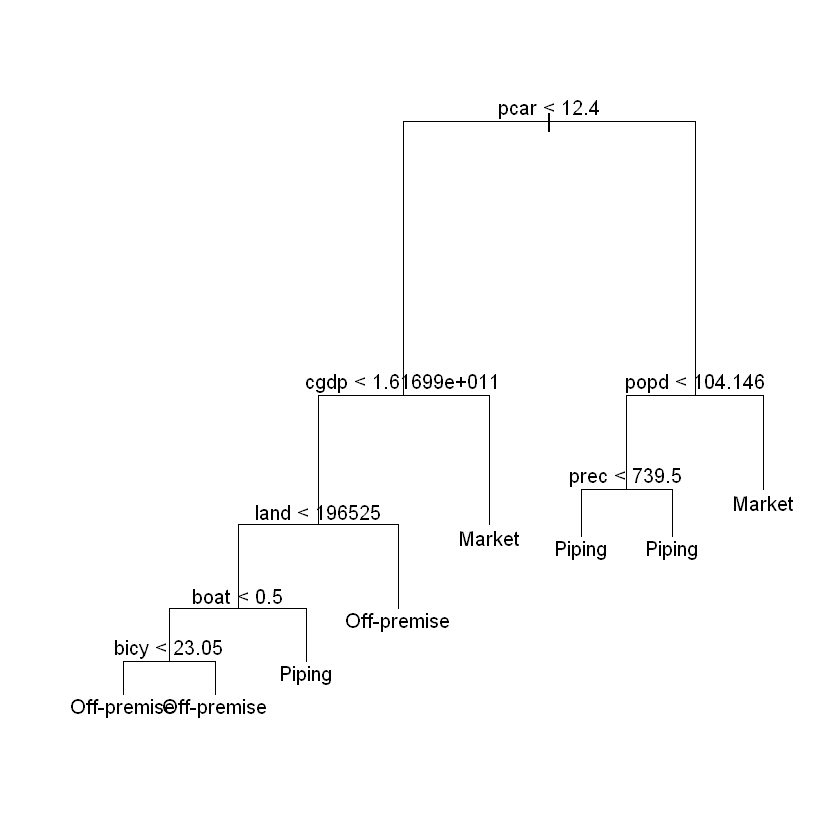

In [35]:
plot(tree.wa)
text(tree.wa)


Classification tree:
snip.tree(tree = tree.wa, nodes = c(16L, 6L))
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "popd"
Number of terminal nodes:  6 
Residual mean deviance:  0.9617 = 64.43 / 67 
Misclassification error rate: 0.1644 = 12 / 73 

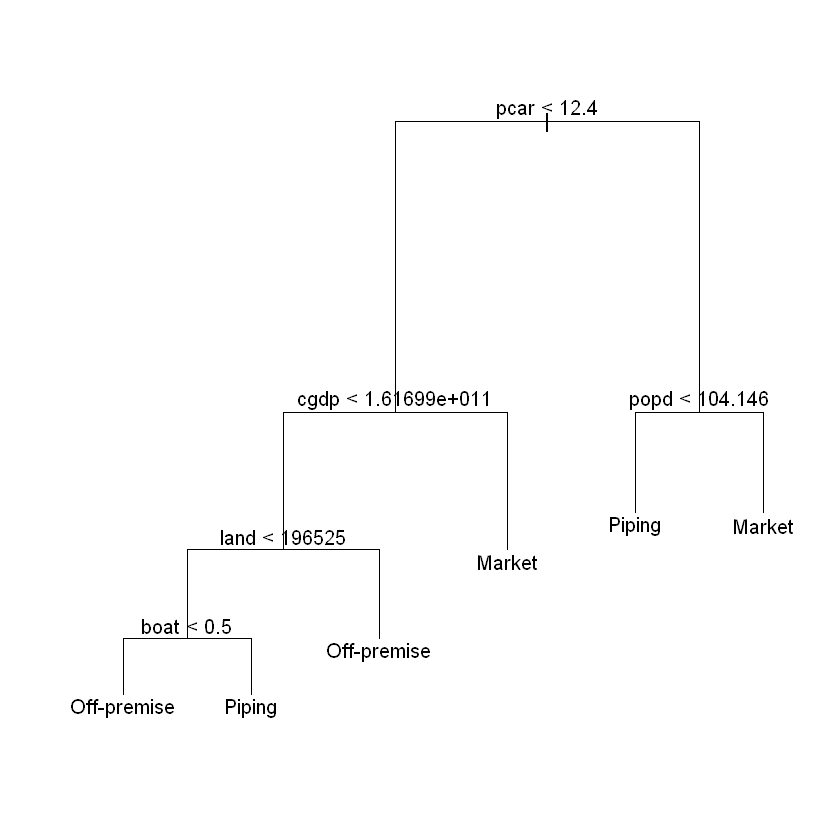

In [52]:
pru.wa <- prune.tree(tree.wa, best = 6 )
summary(pru.wa)
plot(pru.wa)
text(pru.wa, pretty = 0)


# Random Forest


Call:
 randomForest(formula = clusters ~ . - Country, data = df, ntree = 200,      mtry = 12) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 12

        OOB estimate of  error rate: 35.62%
Confusion matrix:
            Market Off-premise Piping class.error
Market           4           4      6   0.7142857
Off-premise      1          30      6   0.1891892
Piping           4           5     13   0.4090909


                Length Class  Mode     
call              5    -none- call     
type              1    -none- character
predicted        73    factor numeric  
err.rate        800    -none- numeric  
confusion        12    -none- numeric  
votes           219    matrix numeric  
oob.times        73    -none- numeric  
classes           3    -none- character
importance       13    -none- numeric  
importanceSD      0    -none- NULL     
localImportance   0    -none- NULL     
proximity         0    -none- NULL     
ntree             1    -none- numeric  
mtry              1    -none- numeric  
forest           14    -none- list     
y                73    factor numeric  
test              0    -none- NULL     
inbag             0    -none- NULL     
terms             3    terms  call     

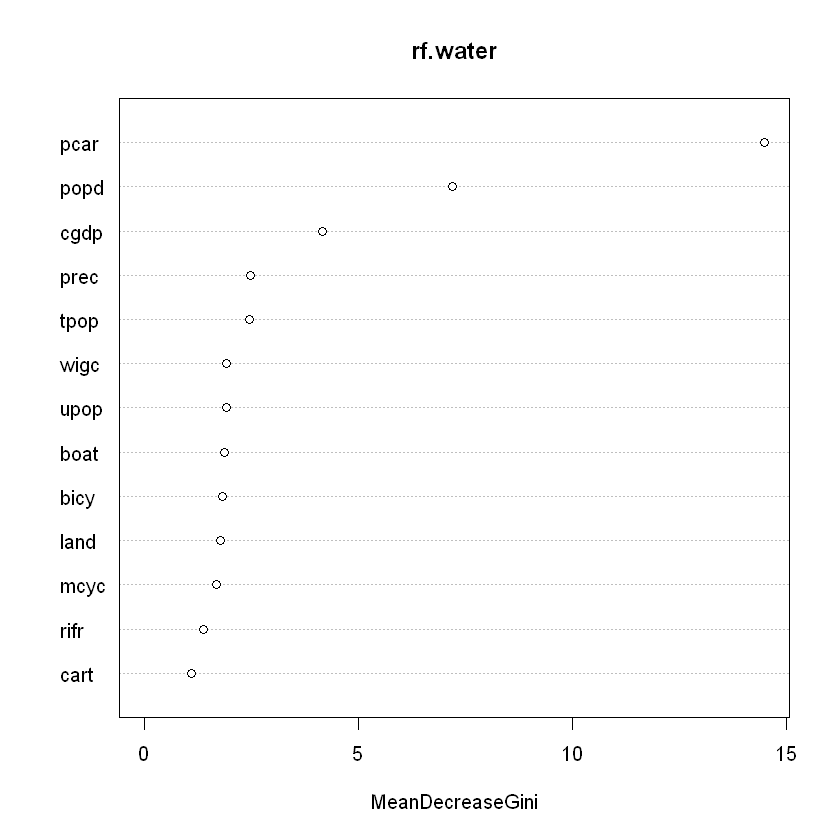

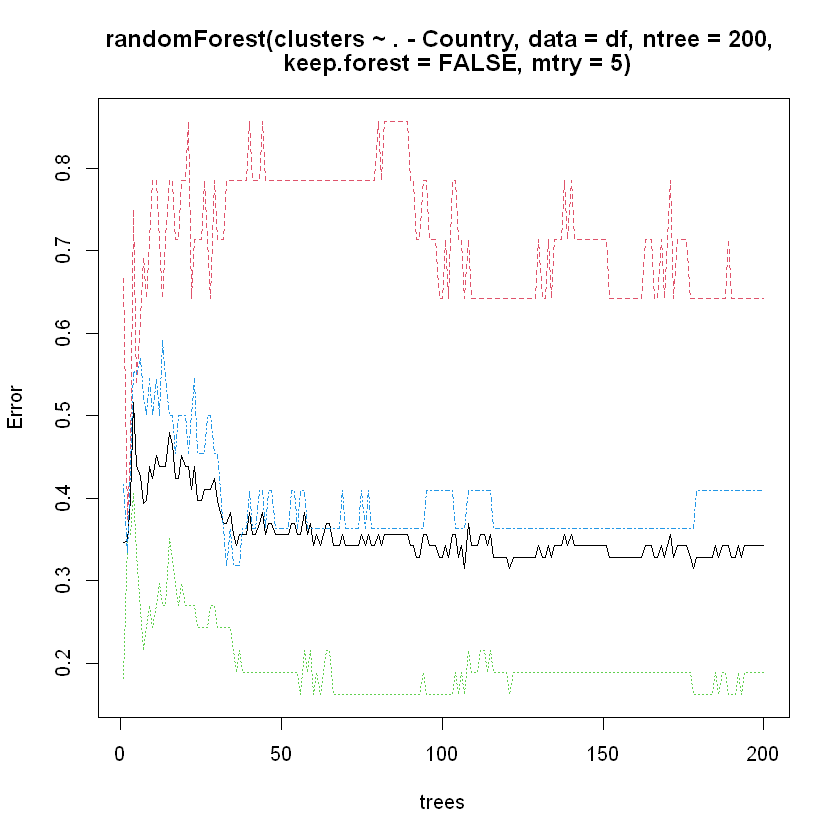

In [54]:
rf.water = randomForest(clusters~. -Country, data = df , ntree= 200,mtry=12)
print(rf.water)

summary(rf.water)

#importance <- importance(rf.water, sort = TRUE)
#importance

# create an importance plot
varImpPlot(rf.water, sort=TRUE, n.var=min(30, nrow(rf.water$importance)),
           type=NULL, class=NULL, scale=TRUE )
#plot
plot(randomForest(clusters~. -Country, data = df ,ntree=200,  keep.forest=FALSE, mtry=5) )

The MeanDecreaseGini measures the Gini importance = how important the features are over all splits done in the tree/forest - whereas for each individual split the Gini importance indicates how much the Gini criterion = "unequality/heterogeneity" was reduced using this split.
mori, upop, pcar popd, mcyc important and contributed most to obtaining such splits, so they are considered more important.

# MULTINOMIAL LOGISTIC REGRESSION

In [38]:
head(df)
with(df, table( df[,8]),)


,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Piping,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Piping,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666



     Market Off-premise      Piping 
         14          37          22 

In [39]:
head(df)

# Fit the model
model <- nnet::multinom(clusters ~. -Country  , data = df)
# Summarize the model
summary(model)

#z values
z <- summary(model)$coefficients/summary(model)$standard.errors
z
# 2-tailed z test
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

## extract the coefficients from the model and exponentiate
exp(coef(model))

# Make predictions
predicted.classes <- model %>% predict(df)
head(predicted.classes)

head(pp <- fitted(model))
# Model accuracy
mean(predicted.classes == df$clusters)

fit.MLR <- vglm( clusters ~ bicy + cart + mcyc +
                pcar+boat+wigc+cgdp+tpop+upop+popd+land+rifr+prec ,
                family=multinomial, df)
summary(fit.MLR)




,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Piping,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Piping,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# weights:  45 (28 variable)
initial  value 80.198697 
iter  10 value 57.505750
iter  20 value 47.926370
iter  30 value 38.017128
iter  40 value 31.286721
iter  50 value 30.210540
iter  60 value 29.848854
iter  70 value 29.813175
iter  80 value 29.805295
iter  80 value 29.805295
final  value 29.805288 
converged


Call:
nnet::multinom(formula = clusters ~ . - Country, data = df)

Coefficients:
            (Intercept)       bicy        cart        mcyc         pcar
Off-premise   0.6599492 0.01412281  0.06893226 -0.05789010 -0.241815900
Piping       -0.2660942 0.01744733 -0.01970541 -0.02598926 -0.003180846
                 boat       wigc          cgdp          tpop        upop
Off-premise 0.1826939  0.2772184 -5.319409e-11  2.281753e-08 0.049523967
Piping      0.8844249 -0.3722652 -1.917004e-11 -4.401958e-08 0.006985658
                    popd         land          rifr          prec
Off-premise -0.003017961 1.783535e-05 -7.198890e-05  0.0009606536
Piping      -0.001980307 1.728218e-05 -3.707888e-05 -0.0001789754

Std. Errors:
             (Intercept)         bicy         cart         mcyc         pcar
Off-premise 1.458464e-23 2.460251e-22 6.223769e-23 3.878404e-22 1.449204e-22
Piping      6.924063e-24 1.889863e-22 2.098252e-23 2.401346e-22 7.883162e-23
                    boat         wigc    

,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Off-premise,4.524961e+22,5.740391e+19,1.107565e+21,-1.492627e+20,-1.668612e+21,3.143761e+22,7.967996e+22,-15.026573,12391736,7.259182e+19,-1.217217e+18,1.608949e+12,-9.869990e+14,7.647895e+16
Piping,-3.843036e+22,9.232061e+19,-9.391347e+20,-1.082279e+20,-4.034988e+19,1.012423e+23,-3.177861e+23,-7.511125,-58757955,2.003331e+19,-2.090934e+18,3.050290e+12,-6.482155e+14,-1.956752e+16


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Off-premise,0,0,0,0,0,0,0,0.000000e+00,0,0,0,0,0,0
Piping,0,0,0,0,0,0,0,5.861978e-14,0,0,0,0,0,0


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Off-premise,1.9346941,1.014223,1.0713636,0.9437537,0.7852007,1.200447,1.3194545,1,1,1.050771,0.9969866,1.000018,0.9999280,1.000961
Piping,0.7663669,1.017600,0.9804875,0.9743456,0.9968242,2.421591,0.6891714,1,1,1.007010,0.9980217,1.000017,0.9999629,0.999821


[1] Off-premise Piping      Off-premise Piping      Market      Market     
Levels: Market Off-premise Piping

,Market,Off-premise,Piping
1,5.830354e-05,0.7388941981,2.610475e-01
2,4.970834e-01,0.0036231014,4.992935e-01
3,5.590635e-09,0.6922257010,3.077743e-01
4,4.625832e-01,0.0018902462,5.355266e-01
5,4.884881e-01,0.0639187499,4.475932e-01
6,9.994184e-01,0.0005791787,2.457843e-06


[1] 0.8219178

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working w

Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta 

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(e


Call:
vglm(formula = clusters ~ bicy + cart + mcyc + pcar + boat + 
    wigc + cgdp + tpop + upop + popd + land + rifr + prec, family = multinomial, 
    data = df)

Coefficients: 
                Estimate Std. Error z value Pr(>|z|)  
(Intercept):1 -8.524e+00  4.954e+00      NA       NA  
(Intercept):2  2.116e+00  2.135e+00   0.991   0.3215  
bicy:1         1.145e-01  8.862e-02   1.292   0.1965  
bicy:2        -4.629e-03  4.648e-02  -0.100   0.9207  
cart:1        -2.589e-01  2.009e-01      NA       NA  
cart:2         5.103e-03  8.117e-02   0.063   0.9499  
mcyc:1         8.432e-02  6.420e-02   1.313   0.1891  
mcyc:2        -1.030e-02  4.744e-02  -0.217   0.8281  
pcar:1         1.372e-01  7.788e-02   1.761   0.0782 .
pcar:2        -2.261e-01  9.518e-02      NA       NA  
boat:1        -2.559e+00  1.561e+00      NA       NA  
boat:2        -1.758e+00  1.309e+00  -1.343   0.1793  
wigc:1         1.096e+01  7.047e+00   1.556   0.1198  
wigc:2         8.587e+00  4.585e+00   1.873   0.